https://www.kaggle.com/datasets/thedevastator/c-ssrs-labeled-suicidality-in-500-anonymized-red

In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("thedevastator/c-ssrs-labeled-suicidality-in-500-anonymized-red")

# print("Path to dataset files:", path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [3]:
CSV_PATH = "/Users/iliakozhevnikov/Downloads/500_anonymized_Reddit_users_posts_labels - 500_anonymized_Reddit_users_posts_labels.csv"

In [4]:
df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH, "shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Loaded: /Users/iliakozhevnikov/Downloads/500_anonymized_Reddit_users_posts_labels - 500_anonymized_Reddit_users_posts_labels.csv shape: (500, 3)
Columns: ['User', 'Post', 'Label']


,User,Post,Label
0,user-0,"['Its not a viable option, and youll be leavin...",Supportive
1,user-1,['It can be hard to appreciate the notion that...,Ideation
2,user-2,"['Hi, so last night i was sitting on the ledge...",Behavior
3,user-3,['I tried to kill my self once and failed badl...,Attempt
4,user-4,['Hi NEM3030. What sorts of things do you enjo...,Ideation


In [5]:
text_col_candidates = [c for c in df.columns if any(k in c.lower() for k in ['text','post','content','message','body','comment','posts'])]
label_col_candidates = [c for c in df.columns if any(k in c.lower() for k in ['label','target','class','y','sentiment'])]
text_col = text_col_candidates[0] if text_col_candidates else df.select_dtypes(include=['object']).columns[0]
label_col = label_col_candidates[0] if label_col_candidates else (df.columns[1] if df.shape[1] >= 2 else None)
print("Using text_col:", text_col, "label_col:", label_col)

Using text_col: Post label_col: Label


In [6]:
url_re = re.compile(r'http\S+|www\.\S+')
mention_re = re.compile(r'@\w+')
non_letter_re = re.compile(r'[^A-Za-zА-Яа-яёЁ\s]')
multi_space_re = re.compile(r'\s+')

RU_STOPWORDS = {
    'и','в','не','на','что','я','с','по','это','как','а','он','она','они','бы','его','ее','из','за','же',
    'то','для','о','к','у','или','от','мы','вы','там','когда','где','тот','та'
}

In [7]:
def detect_language(text):
    if not isinstance(text, str) or text.strip() == "":
        return None
    return 'ru' if re.search(r'[а-яА-ЯёЁ]', text) else 'en'

def simple_stem_en(token):
    for suf in ['ing','ed','s','es','ly','ment','ness','ation','ions']:
        if token.endswith(suf) and len(token) - len(suf) >= 3:
            return token[:-len(suf)]
    return token

def simple_stem_ru(token):
    for suf in ['ами','ями','ого','его','ому','ему','ою','ей','ах','ях','ие','ия','ое','ая','ые','ам','ах','ом','ем','ой','ий','ый']:
        if token.endswith(suf) and len(token) - len(suf) >= 2:
            return token[:-len(suf)]
    return token

In [8]:
USE_NLTK = False
try:
    from nltk.stem.snowball import SnowballStemmer
    USE_NLTK = True
    eng_stemmer = SnowballStemmer("english")
    try:
        rus_stemmer = SnowballStemmer("russian")
    except Exception as err:
        print(err)
        rus_stemmer = None
except Exception as err:
    print(err)
    USE_NLTK = False
    eng_stemmer = None
    rus_stemmer = None

In [9]:
def preprocess_text(text, do_stemming=True, remove_stopwords=True):
    if not isinstance(text, str):
        return ""
    t = text.strip()
    t = url_re.sub(' ', t)
    t = mention_re.sub(' ', t)
    t = non_letter_re.sub(' ', t)
    t = multi_space_re.sub(' ', t)
    t = t.lower().strip()
    lang = detect_language(t)
    tokens = [tok for tok in t.split() if len(tok) >= 2]
    stopset = set(ENGLISH_STOP_WORDS) | RU_STOPWORDS if remove_stopwords else set()
    cleaned_tokens = []
    for tok in tokens:
        if tok in stopset:
            continue
        if do_stemming:
            if lang == 'en':
                tok2 = eng_stemmer.stem(tok) if USE_NLTK and eng_stemmer else simple_stem_en(tok)
            elif lang == 'ru':
                tok2 = rus_stemmer.stem(tok) if USE_NLTK and rus_stemmer else simple_stem_ru(tok)
            else:
                tok2 = simple_stem_en(tok)
        else:
            tok2 = tok
        if len(tok2) >= 2:
            cleaned_tokens.append(tok2)
    return " ".join(cleaned_tokens)

In [10]:
df['_raw_text'] = df[text_col].astype(str)
df['_clean_text'] = df['_raw_text'].map(lambda t: preprocess_text(t, do_stemming=True, remove_stopwords=True))
df['_word_count'] = df['_clean_text'].map(lambda t: len(t.split()) if isinstance(t, str) and t.strip() else 0)
df['_char_count'] = df['_raw_text'].map(lambda t: len(str(t)))
df['_lang'] = df['_raw_text'].map(detect_language)

In [11]:
initial_n = len(df)
df = df[df['_word_count'] >= 2].copy()
df = df[df['_char_count'] <= 10000].copy()
df = df.drop_duplicates(subset=['_clean_text'])
filtered_n = len(df)
print(f"Filtered: {initial_n} -> {filtered_n} (removed {initial_n - filtered_n})")

Filtered: 500 -> 388 (removed 112)


In [12]:
if label_col is not None:
    try:
        df['_label_clean'] = pd.to_numeric(df[label_col], errors='coerce')
        if df['_label_clean'].isna().all():
            df['_label_clean'] = df[label_col].astype('category')
    except Exception as err:
        print(err)
        df['_label_clean'] = df[label_col].astype('category')
else:
    df['_label_clean'] = 'UNKNOWN'

print("Label counts:")
print(df['_label_clean'].value_counts(dropna=False).head(30))

Label counts:
_label_clean
Ideation      135
Supportive     89
Indicator      75
Behavior       57
Attempt        32
Name: count, dtype: int64


In [13]:
grouped = df.groupby('_label_clean').agg(
    n_obs = ('_clean_text','count'),
    mean_words = ('_word_count','mean'),
    median_words = ('_word_count','median'),
    vocab_size = ('_clean_text', lambda s: len(set(" ".join(s).split())))
).reset_index()
grouped

,_label_clean,n_obs,mean_words,median_words,vocab_size
0,Attempt,32,264.593750,223.0,1880
1,Behavior,57,312.929825,227.0,2784
2,Ideation,135,244.659259,184.0,3839
3,Indicator,75,224.786667,165.0,2807
4,Supportive,89,217.539326,131.0,2759


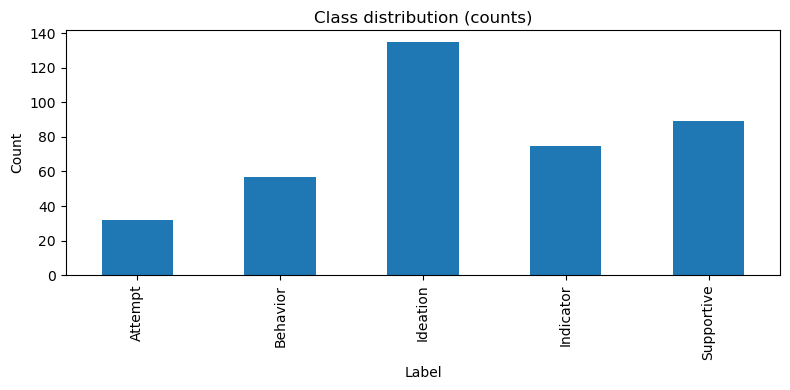

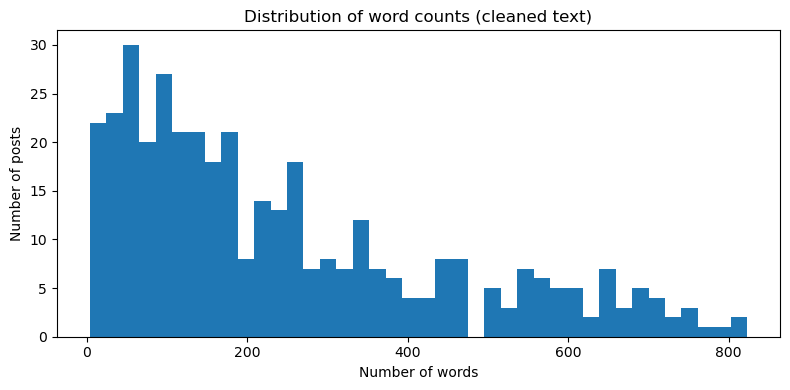

In [14]:
plt.figure(figsize=(8,4))
if df['_label_clean'].dtype.name in ['category','object'] or df['_label_clean'].nunique() < 30:
    df['_label_clean'].value_counts().sort_index().plot(kind='bar')
    plt.title('Class distribution (counts)')
    plt.xlabel('Label')
    plt.ylabel('Count')
else:
    plt.hist(df['_label_clean'].dropna(), bins=30)
    plt.title('Label distribution (numeric)')
    plt.xlabel('Label value')
    plt.ylabel('Frequency')
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.hist(df['_word_count'], bins=40)
plt.title('Distribution of word counts (cleaned text)')
plt.xlabel('Number of words')
plt.ylabel('Number of posts')
plt.tight_layout(); plt.show()

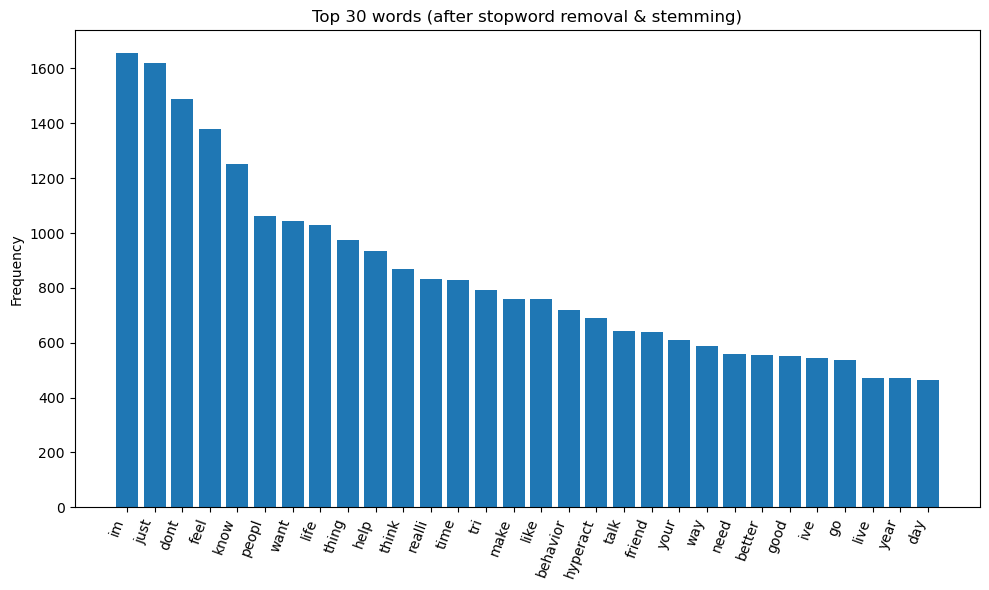

In [15]:
all_tokens = " ".join(df['_clean_text'].tolist()).split()
counter_all = Counter(all_tokens)
top_n = 30
top_words = counter_all.most_common(top_n)
plt.figure(figsize=(10,6))
if top_words:
    words, counts = zip(*top_words)
    plt.bar(range(len(words)), counts)
    plt.xticks(range(len(words)), words, rotation=70, ha='right')
    plt.title(f'Top {top_n} words (after stopword removal & stemming)')
    plt.ylabel('Frequency')
    plt.tight_layout(); plt.show()
else:
    print("No tokens after cleaning to plot top words.")

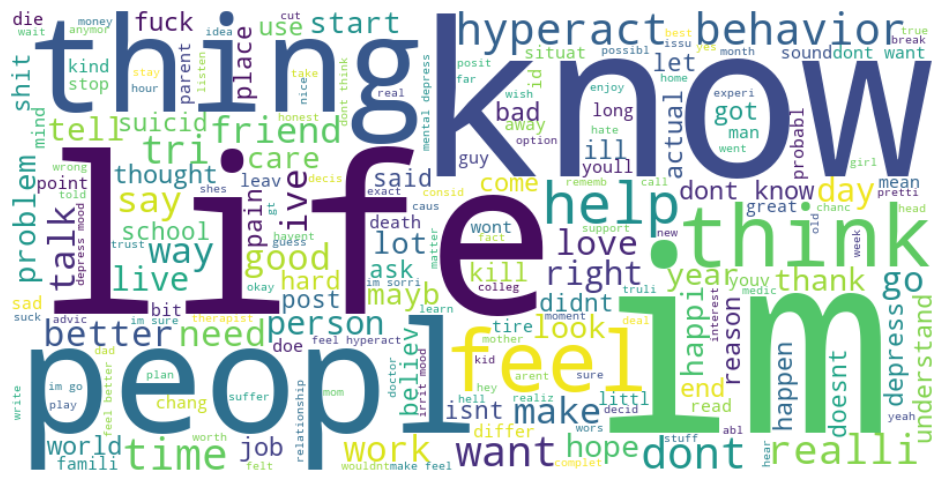

Total tokens: 95553
Vocabulary size: 6430
Avg words per post: 246.27061855670104
Number of unique cleaned texts: 388


In [16]:
try:
    from wordcloud import WordCloud
    wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_tokens))
    plt.figure(figsize=(12,6)); plt.imshow(wc, interpolation='bilinear'); plt.axis('off'); plt.show()
except Exception as err:
    print(err)
    print("wordcloud not available, skipping. Error:", err)

vocab = set(all_tokens)
print("Total tokens:", len(all_tokens))
print("Vocabulary size:", len(vocab))
print("Avg words per post:", df['_word_count'].mean())
print("Number of unique cleaned texts:", df['_clean_text'].nunique())

Был создан файл _clean_text с помощью:

- преобразования в нижний регистр,
- удаления URL/упоминаний,
- удаления небуквенных символов (сохраняются латинские и кириллические символы),
- удаления стоп-слов (sklearn English stopwords + небольшой набор русских слов),
- условного стемминга: простая русско-английская эвристика с использованием стеммера Snowball от nltk

Были отфильтрованы строки с менее чем 2 очищенными токенами, чрезмерно длинные исходные тексты и дубликаты очищенных текстов.

Был построен график распределения классов, распределения количества слов, наиболее частотных слов + облако слов

Сильные стороны:


- Набор данных представляет собой честные данные в стиле постов Reddit (реалистичные короткие тексты).

- Небольшой/средний объем: 500 примеров достаточно для создания прототипа функций и базовых классификаторов (TF-IDF + логистическая регрессия), оценки качества меток и стресс-тестирования предварительной обработки.
- Если метки значимы и последовательны, можно быстро получить простой и полезный классификатор.



Слабые стороны/риски:


- Размер: 500 строк — это мало для современных глубоких моделей NLP — ожидайте переобучения. Классические модели (TF-IDF + линейные классификаторы) — правильный первый шаг.

- Баланс меток: небольшие наборы данных часто имеют дисбаланс классов. Если один класс доминирует (~>80%), вам понадобится повторная выборка или тщательные метрики (точность/восстановление, F1) вместо точности.

- Короткий текст: среднее количество слов может быть небольшим — короткие тексты уменьшают контекст, что усложняет задачи. Помочь могут n-граммы символов или функции на основе подслов.

- Смешение языков: если посты содержат несколько языков (английский + русский), вам нужно либо разделить языки, либо создать многоязычную предварительную обработку/модели.

- Качество меток: всегда проверяйте шум меток. При ограниченном объеме данных шумные метки губительны для производительности модели.